# Importing libraries

In [ ]:
import os
import numpy as np
np.set_printoptions(suppress=True)

import tensorflow as tf
from tensorflow import keras
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score ,r2_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image


from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import SGD




# Importing the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# reading csv
dataset = pd.read_csv(r'/content/drive/MyDrive/Projet/daily/data/dataset_btc.csv',sep=',' )
dataset=dataset[:]

In [ ]:
print(dataset.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volubtc', 'voluusdt',
       'tradecount', 'tenkan_sen', 'kijun_sen', 'senkou_span_a',
       'senkou_span_b', 'chikou_span', 'MACD', 'MA_window_10', 'MA_window_20',
       'Day_dif', 'Close_off_high', 'Volatility', 'avg-block-size',
       'n-transactions-per-block', 'transaction-fees', 'cost-per-transaction',
       'miners-revenue', 'TrendGoogle', 'open_microsoft', 'open_fb',
       'open_tesla', 'open_apple', 'fng_value'],
      dtype='object')


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1318 non-null   object 
 1   open                      1318 non-null   float64
 2   high                      1318 non-null   float64
 3   low                       1318 non-null   float64
 4   close                     1318 non-null   float64
 5   volubtc                   1318 non-null   float64
 6   voluusdt                  1318 non-null   float64
 7   tradecount                1318 non-null   float64
 8   tenkan_sen                1318 non-null   float64
 9   kijun_sen                 1318 non-null   float64
 10  senkou_span_a             1318 non-null   float64
 11  senkou_span_b             1318 non-null   float64
 12  chikou_span               1318 non-null   float64
 13  MACD                      1318 non-null   float64
 14  MA_windo


# Parameter settings

In [ ]:


# number of total past observations from the original dataset to be considered
n_past_total =310  

# number of past observations to be considered for the LSTM training and prediction
n_past = 7

# number of future datapoints to predict (if higher than 1, the model switch to Multi-Step)
n_future = 1

# activation function used for the RNN (softsign, relu, sigmoid)
activation = 'softsign'

# dropout for the hidden layers
dropout = 0.2

# number of hidden layers
n_layers = 2

# number of neurons of the hidden layers
n_neurons = 64

# patience for the early stopping (number of epochs)
patience = 5

# optimizer (adam, RMSprop)

# lr=0.02
# momentum=0.9
optimizer='adam'
# optimizer=SGD(lr=lr, momentum=momentum)##

# batch size
batch_size=1

# features to be considered for training (if only one is Close, then its Univariate, if more, then it's Multivariate)
''' 
features = [   'close', 'volubtc', 'tradecount', 'senkou_span_b', 'MACD',
       'Day_dif', 'Close_off_high', 'Volatility', 'close_t-7',
       'miners-revenue', 'TrendGoogle', 'open_microsoft', 'open_apple',
       'fng_value']
  '''  
features = ['close']
  
# number of inputs features (if higher than 1, )
n_features = len(features)


# EDA (brief)

In [ ]:
dataset=dataset[1008:]





dataset = dataset.drop('TrendGoogle', 1)
dataset = dataset.drop('open_microsoft', 1)
dataset = dataset.drop('open_apple', 1)
dataset = dataset.drop('fng_value', 1)

dataset = dataset.drop('open_tesla', 1)

dataset = dataset.drop('volubtc', 1)
dataset = dataset.drop('tradecount', 1)
dataset = dataset.drop('senkou_span_b', 1)
dataset = dataset.drop('Day_dif', 1)
dataset = dataset.drop('MACD', 1)
dataset = dataset.drop('Close_off_high', 1)
dataset = dataset.drop('Volatility', 1)
dataset = dataset.drop('miners-revenue', 1)

dataset = dataset.drop('open', 1)
dataset = dataset.drop('high', 1)
dataset = dataset.drop('low', 1)
dataset = dataset.drop('voluusdt', 1)
dataset = dataset.drop('chikou_span', 1)
dataset = dataset.drop('transaction-fees', 1)
dataset = dataset.drop('MA_window_10', 1)
dataset = dataset.drop('MA_window_20', 1)

dataset = dataset.drop('avg-block-size', 1)
dataset = dataset.drop('open_fb', 1)

dataset = dataset.drop('n-transactions-per-block', 1)
dataset = dataset.drop('cost-per-transaction', 1)

dataset = dataset.drop('tenkan_sen', 1)
dataset = dataset.drop('kijun_sen', 1)

dataset = dataset.drop('senkou_span_a', 1)

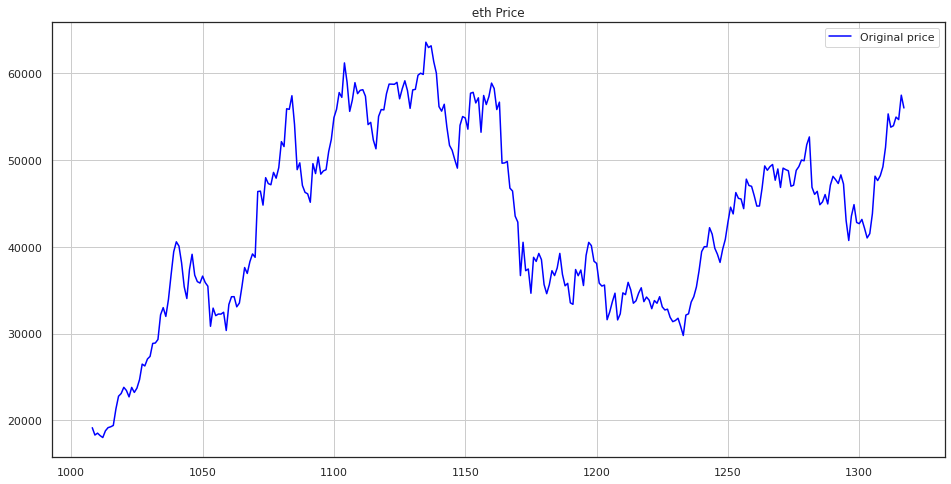

In [ ]:

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(dataset["close"], color='blue', label='Original price')

plt.title(' eth Price ')
plt.grid()
plt.legend()

In [ ]:
# checking for nulls
dataset.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 1008 to 1317
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    310 non-null    object 
 1   close   310 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [ ]:
dataset

,date,close
1008,2020-12-07,19166.900
1009,2020-12-08,18324.110
1010,2020-12-09,18541.280
1011,2020-12-10,18254.630
1012,2020-12-11,18036.530
...,...,...
1313,2021-10-08,53951.430
1314,2021-10-09,54949.720
1315,2021-10-10,54659.000
1316,2021-10-11,57471.350


In [ ]:
# checking the main parameters
dataset.describe()

,close
count,310.000
mean,43084.095
std,10618.390
min,18036.530
25%,34786.505
50%,43809.235
75%,51251.620
max,63575.000


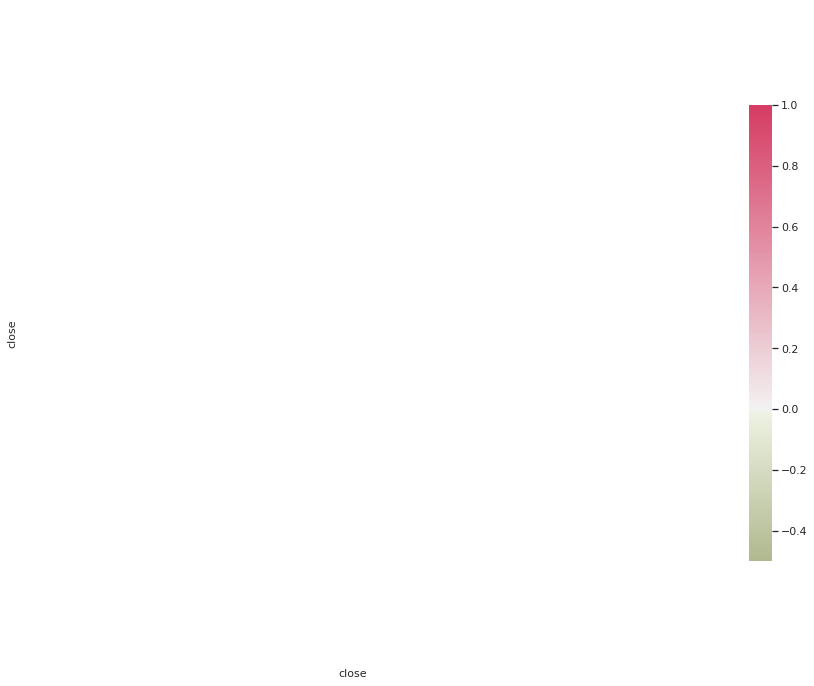

In [ ]:
# looking at the correlation of the main possible variables
'''dataset[[ 'close', 'volubtc', 'tradecount', 'senkou_span_b', 'MACD',
       'Day_dif', 'Close_off_high', 'Volatility', 'close_t-7',
       'miners-revenue', 'TrendGoogle', 'open_microsoft', 'open_apple',
       'fng_value']].corr()'''




import matplotlib.pyplot as plt
import seaborn as sns



sns.set_theme(style="white")




# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(98, 2, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-0.5, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .7},annot=True)

In [ ]:
dataset.info()


df=dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 1008 to 1317
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    310 non-null    object 
 1   close   310 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [ ]:
# use close only and fill NaN with ffil
df = dataset.set_index('date')[features]#.tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)



# Preprocessing the data

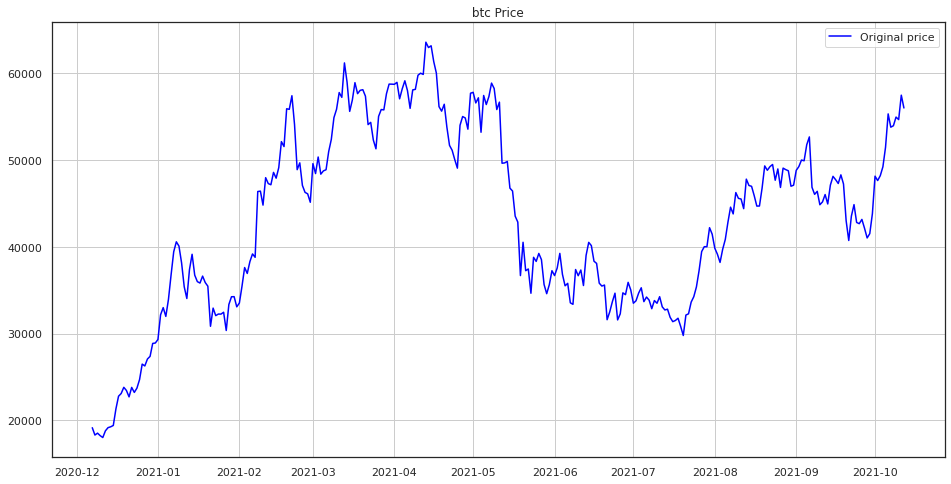

In [ ]:
# droppping firsts observations becuase they may not be representative of BTC behaviour now due to beginnings of crypto market
df = df.tail(n_past_total)
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(df["close"], color='blue', label='Original price')

plt.title(' btc Price ')
plt.grid()
plt.legend()

In [ ]:
# train test split
training_set = df
training_set = training_set.values
print('training_set.shape:', training_set.shape)

training_set.shape: (310, 1)


In [ ]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape: ', training_set_scaled.shape)



training_set_scaled.shape:  (310, 1)


In [ ]:
# creating a data structure with timesteps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape


X_testf =X_train[280:]
y_testf=y_train[280:]

In [ ]:
X_train=X_train[:280]
y_train=y_train[:280]

In [ ]:
X_test = X_train[-1].reshape(1, n_past, n_features)
y_test  = y_train[-1]

X_test

array([[[0.61461683],
        [0.59080158],
        [0.63847095],
        [0.66064758],
        [0.65222415],
        [0.64260942],
        [0.66440989]]])

In [ ]:
X_train.shape

(280, 7, 1)

In [ ]:
X_train

array([[[0.02482231],
        [0.0063151 ],
        [0.01108404],
        ...,
        [0.        ],
        [0.01695621],
        [0.02499996]],

       [[0.0063151 ],
        [0.01108404],
        [0.00478936],
        ...,
        [0.01695621],
        [0.02499996],
        [0.02715528]],

       [[0.01108404],
        [0.00478936],
        [0.        ],
        ...,
        [0.02499996],
        [0.02715528],
        [0.03052145]],

       ...,

       [[0.58882918],
        [0.59591725],
        [0.61461683],
        ...,
        [0.63847095],
        [0.66064758],
        [0.65222415]],

       [[0.59591725],
        [0.61461683],
        [0.59080158],
        ...,
        [0.66064758],
        [0.65222415],
        [0.64260942]],

       [[0.61461683],
        [0.59080158],
        [0.63847095],
        ...,
        [0.65222415],
        [0.64260942],
        [0.66440989]]])

In [ ]:
# reshaping (needed to fit RNN)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape



(280, 7, 1)

# GridSearch





In [ ]:
# Building the RNN

def create_model(activation='relu',learn_rate=0.01, momentum=0,n_neurons=64, optimizer='adam',dropout=0.1,n_layers=1):
  # Initialising the RNN
  regressor = Sequential()

  # Input layer
  regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
  #regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

  # Hidden layers
  for _ in range(n_layers):
      regressor.add(Dropout(dropout))
      regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

  # Last hidden layer (changing the return_sequences)
  regressor.add(Dropout(dropout))
  regressor.add(LSTM(units=n_neurons, return_sequences=False))

  # Adding the output layer
  regressor.add(Dense(units=n_future,))

  # Compiling the RNN
  regressor.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()],
  )


  # Model summary
  regressor.summary()
  return regressor

In [ ]:
'''pip install scikeras'''

In [ ]:
'''from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import  KerasRegressor

#tu appelles ton model :
model =  KerasRegressor(model=create_model,  verbose=0)

# define the grid search parameters
batch_size = [1,10, 20]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [ 0.2, 0.4]
optimizer = ['SGD', 'Adam',]
activation =  [ 'softsign', 'relu', 'tanh', 'sigmoid']
epochs = [3,7,10]
n_neurons=[32, 64,  128]
dropout=[0, 0.1,  0.2]
n_layers=[1,3,6]

param_grid = dict(epochs=epochs, batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, scoring="r2", error_score="raise")
grid_result = grid.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))'''

# BUILD LSTM

In [ ]:
  # Initialising the RNN
regressor = Sequential()

  # Input layer
regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
  #regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

  # Hidden layers
for _ in range(n_layers):
   regressor.add(Dropout(dropout))
   regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

  # Last hidden layer (changing the return_sequences)
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons, return_sequences=False))

  # Adding the output layer
regressor.add(Dense(units=n_future,))

  # Compiling the RNN
regressor.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()],
  )


  # Model summary
regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 7)              252       
                                                                 
 dropout (Dropout)           (None, 7, 7)              0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             18432     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [ ]:
#  Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [ ]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=batch_size
                    , epochs=10
                    , validation_split=0.05
                    , callbacks=[early_stop]
                   )



Epoch 1/10
266/266 [==============================] - 17s 36ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/10
266/266 [==============================] - 10s 36ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 3/10
266/266 [==============================] - 9s 33ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 4/10
266/266 [==============================] - 9s 33ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 5/10
266/266 [==============================] - 9s 33ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 6/10
266/266 [==============================] - 13s 47ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 7/10
266/266 

In [ ]:
# Exporting the regressor
last_date = dataset.date.values[-1]
params = ['reg', last_date, n_past_total, n_past, n_future, activation, n_layers, n_neurons,batch_size ,n_features, patience, optimizer]
modelname = 'output/'
for i in params:
    modelname += str(i)
    if i!= params[-1]:
        modelname += '_'
if not os.path.exists(modelname):
    os.makedirs(modelname)
regressor.save('{}/regressor.h5'.format(modelname))

In [ ]:
list(res.history)

['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']

In [ ]:
# Loads the weights
#regressor.load_weights(checkpoint_path)

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('C:\Users\yonas\output\reg_2021-10-29_700_90_7_softsign_6_64_5_19_25_adam\regressor.h5')



# Validation

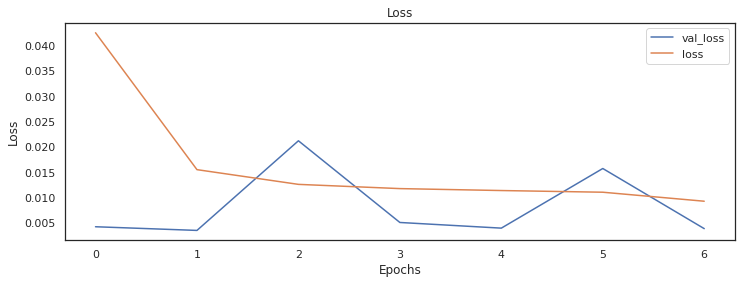

In [ ]:


# Plotting Loss/MSE

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('{}/Loss.png'.format(modelname))
plt.show()



In [ ]:


def dummy_invscaler(y, n_features):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    y = np.array(y).reshape(-1,1)
    if n_features>1:
        dummy = np.ones((len(y), n_features-1))
        y = np.concatenate((y, dummy), axis=1)
        y = sc.inverse_transform(y)
        y = y[:,0]
    else:
        y = sc.inverse_transform(y)
    return y



In [ ]:
X_test

array([[[0.61461683],
        [0.59080158],
        [0.63847095],
        [0.66064758],
        [0.65222415],
        [0.64260942],
        [0.66440989]]])

y_pred:
 [[45297.73237565279]]
y_true:
 [[55996.93]]


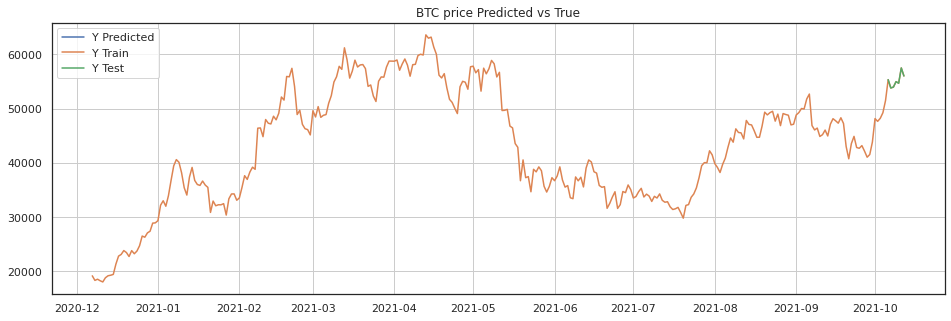

In [ ]:


# Validation

# getting the predictions


y_pred = regressor.predict(X_test).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)
#X_test = 

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['close']].tail(n_future).index, 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']]#.tail(n_future)
y_true = y_true_df.tail(n_future).values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())


# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Y Predicted')
plt.plot(y_true_df, label='Y Train')
plt.plot(y_true_df.tail(n_past), label='Y Test')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Validation.png'.format(modelname))
plt.grid()
plt.show()



In [ ]:
listetrue =[]
listepred=[]

for i in range(30,0,-1):
  
  X_test = X_train[-i].reshape(1, n_past, n_features)
  y_test  = y_train[-i]
  y_pred = regressor.predict(X_test).tolist()[0]
  y_pred = dummy_invscaler(y_pred, n_features)
  # creating a DF of the predicted prices
  y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['close']].tail(n_future).index, 
                         columns=df[['close']].columns)
  
  # getting the true values
  y_true_df = df[['close']]#.tail(n_future)
  y_true = y_true_df.tail(i).head(1).values
  '''print('-----------------------------')
  print(i)
  print('y_pred:\n', y_pred.tolist())
  print('y_true:\n', y_true.tolist())'''
  y_true.tolist()
  listetrue.append(y_pred.tolist())
  listepred.append(y_true.tolist())

 

In [ ]:
print('true',str(np.shape(listetrue)))
print('pred',str(np.shape(listepred)))

true (30, 1, 1)
pred (30, 1, 1)


In [ ]:
listetrue = np.array(listetrue).reshape(30,1)
listepred = np.array(listepred).reshape(30,1)
print('true',str(np.shape(listetrue)))

true (30, 1)


In [ ]:
for i in range (len(listetrue)):
  print(i,'  true',listetrue[i],'pred',listepred[i] )

0   true [44839.94323631] pred [44940.73]
1   true [44795.41778811] pred [47111.52]
2   true [44919.4017812] pred [48121.41]
3   true [45375.9694836] pred [47737.82]
4   true [46099.31530118] pred [47299.98]
5   true [46821.03253616] pred [48292.74]
6   true [47119.57886919] pred [47241.75]
7   true [46957.86061733] pred [43015.62]
8   true [46878.64635982] pred [40734.38]
9   true [46743.25143134] pred [43543.61]
10   true [46549.1895291] pred [44865.26]
11   true [46618.33914616] pred [42810.57]
12   true [46456.57746543] pred [42670.64]
13   true [46676.19725722] pred [43160.9]
14   true [46574.05798536] pred [42147.35]
15   true [46580.26831366] pred [41026.54]
16   true [46728.56704492] pred [41524.28]
17   true [47317.62537018] pred [43824.1]
18   true [47872.25545934] pred [48141.61]
19   true [48015.0332956] pred [47634.9]
20   true [47917.82320039] pred [48200.01]
21   true [47496.29173826] pred [49224.94]
22   true [46900.38250888] pred [51471.99]
23   true [45880.54780095] p

In [ ]:
# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(listepred, listetrue))
moy = y_true.mean()
Nrmse = rmse/moy
Nrmse

0.10298081877303011

In [ ]:


def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


Mape= mape(listepred, listetrue)
Mape

9.109557908871395

In [ ]:
#Explained variance regression score function.
explained_variance_score(listepred, listetrue)
# Best possible score is 1.0, lower values are worse.

-0.29454105152892085

In [ ]:


# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse



In [ ]:


# mean_absolute_error (MaE)
mse = mean_absolute_error(y_true, y_pred)
mse



In [ ]:


#Explained variance regression score function.
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.




# Predictions

In [ ]:
# Predicting/Forecasting

# getting the predictions
x = df[features][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['close']].index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']].tail(n_past)

# linking them
#y_true_df = y_true_df.append(y_pred_df.head(1))
y_pred_df = y_pred_df.append(y_true_df.tail(1)).sort_index()

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Predictions.png'.format(modelname))
plt.show()

In [ ]:
# export to csv
#y_pred_df.to_csv('{}/preds_{}.csv'.format(modelname,n_future))
# show
y_pred_df

# cross validation

In [ ]:
''x=np.array(x)
y=np.array(y)

for train, test in kfold.split(x,y):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, 8))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, 8))

    output_size=1 
    neurons=100 
    activ_func="tanh"
    dropout=0.25
    loss="mean_squared_error" 
    optimizer="sgd"
    model = Sequential()
    model.add(LSTM(neurons,return_sequences=True,input_shape=(1,8)))
    model.add(LSTM(90))
 
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer='adam',metrics =["mae"])
    model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))





# SHAP

https://medium.datadriveninvestor.com/time-step-wise-feature-importance-in-deep-learning-using-shap-e1c46a655455

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
#%tensorflow_version 2.4.0

In [ ]:
X100 = shap.utils.sample(X_test, 100) # 100 instances for use as the background distribution

In [ ]:

# model

model = load_model('regressor.h5')

model.fit(X_train, y_train)

print("Model coefficients:\n")
for i in range(dataset.shape[1]):
    print(dataset.columns[i], "=", model.coef_[i].round(4))

In [ ]:
X_test.shape
X_test=X_test.reshape(7,15)

In [ ]:
X_test.shape

In [ ]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(regressor.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
import shap

model = load_model('regressor.h5')
# Explainability module
Helper.explainable_forecast(dataset, ff_full_features_, fc, specific_prediction_sample_to_explain=df_full_features.shape[0]+2, input_label_index_value=0, num_labels=1)

## lime